# CutMix 또는 Mixup 비교실험하기

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터셋로드

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


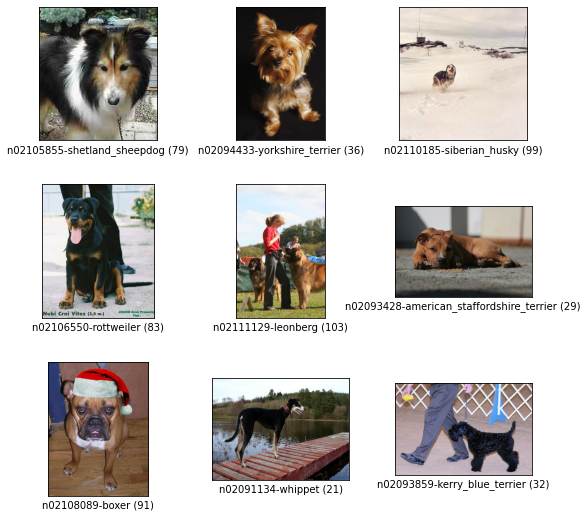

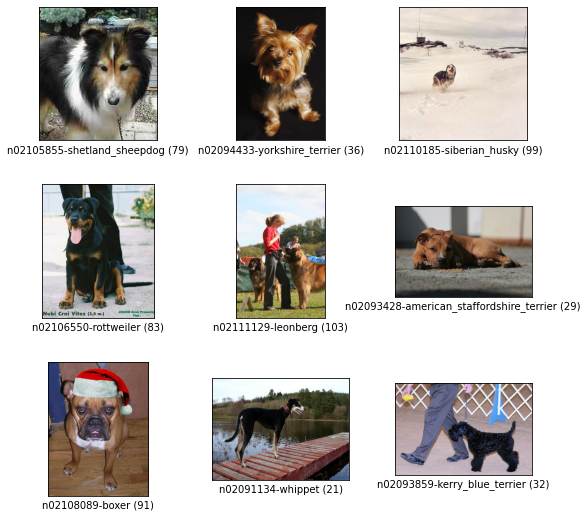

In [5]:
tfds.show_examples(ds_train, ds_info)

In [6]:
num_classes = ds_info.features["label"].num_classes

In [7]:
print(num_classes)

120


In [8]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


## 하이퍼파라미터

In [9]:
BATCH_SIZE = 16
EPOCH = 20
LEARNING_RATE = 0.01

## Cutmix Augmentaion

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img


In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


## Mixup Augmetaion

In [13]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [14]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    #print(image)
    #print(label)

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [16]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,with_mixup=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
        )
    
    if not is_test and with_aug:
        ds = ds.map(ㅊ
            augment
        )
        
    #print(batch_size)
    ds = ds.batch(batch_size)
    
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    elif not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    #print(ds)
    return ds


## 데이터 전처리

In [17]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True, with_aug=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

16
16
16
16
16


In [18]:
print('No Augmentation:',ds_train_no_aug)
print('Augmentation:',ds_train_aug)
print('Augmentation + CutMix:',ds_train_aug_cutmix)
print('Augmentation + MixUp:',ds_train_aug_mixup)
print('Test:',ds_test)

No Augmentation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>
Augmentation: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>
Augmentation + CutMix: <PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>
Augmentation + MixUp: <PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>
Test: <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>


## 모델 만들기 & 학습하기

In [29]:
model_list = [
    {"name":"res_aug_cm","data":ds_train_aug_cutmix},
    {"name":"res_aug_mx","data":ds_train_aug_mixup},
    {"name":"res_noaug","data":ds_train_no_aug},
    {"name":"res_aug","data":ds_train_aug}
]

In [30]:
print(model_list)

[{'name': 'res_aug_cm', 'data': <PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>}, {'name': 'res_aug_mx', 'data': <PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>}, {'name': 'res_noaug', 'data': <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>}, {'name': 'res_aug', 'data': <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>}]


In [30]:
tf.keras.backend.clear_session()

In [ ]:
for i, data in enumerate(model_list):
    globals()[data["name"]] = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224,224,3),
            pooling='avg',
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    globals()[data["name"]].compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=LEARNING_RATE),
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)],
    )
    
    globals()[data["name"]]._name = data["name"]
    print('----------------------',data['name'],'model tarin start-------------------------')
    
    globals()['history_{}'.format(data["name"])] = globals()[data["name"]].fit(data['data'],
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=EPOCH,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )
    
    tf.keras.backend.clear_session()
    print('----------------------',data['name'],'model train end----------------------------')


---------------------- res_aug_cm model tarin start-------------------------
Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 3.8995 - accuracy: 0.1988 - top_k_categorical_accuracy: 0.4221 - val_loss: 2.9417 - val_accuracy: 0.2702 - val_top_k_categorical_accuracy: 0.5915
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 3.0424 - accuracy: 0.4027 - top_k_categorical_accuracy: 0.6962 - val_loss: 1.5840 - val_accuracy: 0.5665 - val_top_k_categorical_accuracy: 0.8667
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7690 - accuracy: 0.4867 - top_k_categorical_accuracy: 0.7555 - val_loss: 1.2330 - val_accuracy: 0.6583 - val_top_k_categorical_accuracy: 0.9166
Epoch 4/20
750/750 [==============================] - 156s 209ms/step - loss: 2.5919 - accuracy: 0.5362 - top_k_categorical_accuracy: 0.7952 - val_loss: 1.1858 - val_accuracy: 0.6713 - val_top_k_categorical_accuracy: 0.9241
Epoch 5/20
750/750 [=======

In [32]:
res_noaug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

res_noaug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=12)],
)

res_noaug._name = 'res_noaug'
print('----------------------res_noaug model tarin start-------------------------')

history_res_noaug = res_noaug.fit(ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

tf.keras.backend.clear_session()
print('----------------------res_noaug model train end----------------------------')

----------------------res_aug model tarin start-------------------------
Epoch 1/20
750/750 [==============================] - 187s 196ms/step - loss: 2.1775 - accuracy: 0.4560 - top_k_categorical_accuracy: 0.8528 - val_loss: 3.6689 - val_accuracy: 0.1705 - val_top_k_categorical_accuracy: 0.5868
Epoch 2/20
750/750 [==============================] - 163s 218ms/step - loss: 0.7076 - accuracy: 0.8068 - top_k_categorical_accuracy: 0.9902 - val_loss: 1.2237 - val_accuracy: 0.6504 - val_top_k_categorical_accuracy: 0.9693
Epoch 3/20
750/750 [==============================] - 148s 197ms/step - loss: 0.2132 - accuracy: 0.9561 - top_k_categorical_accuracy: 0.9993 - val_loss: 0.9534 - val_accuracy: 0.7214 - val_top_k_categorical_accuracy: 0.9825
Epoch 4/20
750/750 [==============================] - 148s 198ms/step - loss: 0.0631 - accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9051 - val_accuracy: 0.7379 - val_top_k_categorical_accuracy: 0.9869
Epoch 5/20
750/750 [===========

In [ ]:
res_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

res_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LEARNING_RATE),
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=12)],
)

res_aug._name = 'res_aug'
print('----------------------res_aug model tarin start-------------------------')

history_res_aug = res_aug.fit(ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

tf.keras.backend.clear_session()
print('----------------------res_aug model train end----------------------------')
